# Example analysis notebook

In this notebook, we will go through the basics of: 

1. Load pre-processed data

2. Synchronize to behavioral data

3. Process the behavioral data 

4. Create epochs

5. Downsample and annotate the epoched data

6. Save the epoched data and use for plots

7. Example of statistical analyses (TODO)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
import h5py
from mne.preprocessing.bads import _find_outliers

import warnings
warnings.filterwarnings('ignore')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils

## Loading pre-processed data

It's a good idea to setup a sensible directory structure like below. Note that all my data lives on '/sc/arion' which is Minerva. 



In [4]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results 

load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/MS007'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/behav/Day1'
neural_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/neural/Day1'
anat_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/anat'


Let's load in the re-referenced data, the photodiode data for synchronization, and the electrode dataframe

In [5]:
wm_ref_data = mne.io.read_raw_fif(f'{load_dir}/wm_ref_ieeg.fif', preload=True)
anode_list = [x.split('-')[0] for x in wm_ref_data.ch_names]
photodiode = mne.io.read_raw_fif(f'{load_dir}/photodiode.fif', preload=True)

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_df = elec_locs[elec_locs.label.str.lower().isin(anode_list)]
elec_df['label'] = wm_ref_data.ch_names


Opening raw data file /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif...
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Reading 0 ... 1867007  =      0.000 ...  1823.249 secs...
Opening raw data file /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif...
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Reading 0 ... 1867007  =      0.000 ...  1823.249 secs...


## Now process the behavioral data

Here, one should load in their own functions for behavioral stuff. I'll just write the functions relevant to me here for demonstration purposes. 

In [38]:
# Utility functions for image memorability ratings. 
import pandas as pd 
import numpy as np 
import os 
from scipy.stats import norm, zscore, linregress

# Note: Much of the following is ported from: https://github.com/cvzoya/memorability-distinctiveness

def dprime(pHit, pFA, PresentT, AbsentT, criteria=False):
    """
    Note: from: http://nikos-konstantinou.blogspot.com/2010/02/dprime-function-in-matlab.html
    
    
    Parameters
    ----------
    pHit : float
        The proportion of "Hits": P(Yes|Signal)
    pFA : float
        The proportion of "False Alarms": P(Yes|Noise)
    PresentT : int
        The number of Signal Present Trials e.g. length(find(signal==1))
    AbsentT : int
        The number of Signal Absent Trials e.g. length(find(signal==0))

        
    Returns
    -------
    dPrime: float
        signal detection theory sensitivity measure 
    
    beta: float
        optional criterion value
        
    C: float
        optional criterion value
        
    """

    if pHit == 1: 
        # if 100% Hits
        pHit = 1 - (1/(2*PresentT))
    
    if pFA == 0: 
        # if 0% FA 
        pFA = 1/(2*AbsentT)
        
    # Convert to Z-scores
    
    zHit = norm.ppf(pHit) 
    zFA = norm.ppf(pFA) 
    
    # calculate d-prime 
    
    dPrime = zHit - zFA 
    
    if criteria:
        beta = np.exp((zFA**2 - zHit**2)/2)
        C = -0.5 * (zHit + zFA)    
        return dPrime, beta, C
    else:
        return dPrime
    
# def calcMI(pmf):
#     """
    
#     Parameters
#     ----------
    
    
#     Returns
#     -------
    
#     """
        
#     pmf_1 = np.sum(pmf,axis=1) #  marginal over first variable
#     pmf_2 = np.sum(pmf,axis=0) # marginal over second variable
    
#     MI = 0
#     for i in range(np.shape(pmf)[0]):
#         for j in range(np.shape(pmf)[1]):
#             MI += pmf[i, j] * np.log(pmf[i, j] / (pmf_1[i]*pmf_2[j]))
            
#     return MI

def compute_memorability_scores(hits, false_alarms, misses, correct_rejections):
    """
    Parameters
    ----------
    hits : array-like
        TODO
    false_alarms : array-like
        TODO
    misses : array_like 
        TODO
    correct_rejections : array_like 
        TODO
        
    Returns
    -------
    memory_ratings : pandas DataFrame 
        DataFrame with the following ratings added: HR (hit rate), FAR (false alarm rate), ACC (accuracy), DPRIME (d-prime), MI (mutual information)
    """
    
    

    len_args = [len(hits), len(false_alarms), len(misses), len(correct_rejections)]
    if not all(len_args[0] == _arg for _arg in len_args[1:]):
            raise ValueError("All parameters must be the same length.")
    
    memory_ratings = pd.DataFrame(columns = ['HR', 'FAR', 'ACC', 'DPRIME'])
    # , 'MI'
    
    reg = 0.1 # regularization for MI calculation

    nstimuli = len(hits) 

    hm = hits+misses
    fc = false_alarms+correct_rejections

    hrs = hits/hm
    fars = false_alarms/fc
    accs = (hits+correct_rejections)/(hm+fc)

    dp = []
#     mis = []
    for i in range(nstimuli):
        dp.append(dprime(hrs[i], fars[i], hm[i], fc[i]))
#         pmf = np.array([[correct_rejections, misses], 
#                [false_alarms, hits]]) + reg
#         pmf = pmf/np.sum(pmf)
#         mis.append(calcMI(pmf))
    

    memory_ratings['HR'] = hrs
    memory_ratings['FAR'] = fars
    memory_ratings['ACC'] = accs
    memory_ratings['DPRIME'] = dp
#     memory_ratings['MI'] = mis
    
    return memory_ratings

## Synchronize to behavioral data

In order to analyze the neural data with respect to the behavioral data we need to be able to synchronize the two using the photodiode (or TTLs, eventually?) 

In [7]:
# Find the timestamps of ONSET and OFFSET of all the sync signals in the photodiode 

# moving average helps us detect the deflections 
sig = np.squeeze(sync_utils.moving_average(photodiode._data, n=11))
timestamp = np.squeeze(np.arange(len(sig))/wm_ref_data.info['sfreq'])
# normalize
sig =  zscore(sig)
# look for z-scores above 1
trig_ix = np.where((sig[:-1]<=0)*(sig[1:]>0))[0] # rising edge of trigger
neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)
print(f'There are {len(neural_ts)} neural syncs detected')

There are 485 neural syncs detected


Get the .log file and/or .csv file, depending on how your task logs the behavioral data. Eventually this should be fairly standardized across tasks.

In [8]:
log_path = glob(f'{behav_dir}/*.log')[0]

In [9]:
csv_path = glob(f'{behav_dir}/*MB_MEM*.csv')[0]

The next step pulls relevant timestamps from the behavioral logfile. THIS STEP DIFFERS DEPENDING ON YOUR TASK. 

Maybe one day this step will be unified across all tasks (i.e. either we have a programmer make our tasks, or we unify best practices for task design). 

In [10]:
# Now get the relevant timestamps from behavioral logfiles. This will differ depending

MB1_ts = {'trial_start': [], 
'deck_start': [], 
'feedback_start': [],
'ITI_start': [],
'ITI_stop': []}

MEM2_ts = {'trial_start': [], 
'face_start': [], 
'slider_start': [],
'slider_stop': [],
'ITI_start': [],
'ITI_stop': []}

beh_ts = []

MB1_FLAG = True 
MEM2_FLAG = False 

with open(log_path, 'r') as fobj:
    for ix, line in enumerate(fobj.readlines()):
        line = line.replace('\r', '')
        tokens = line[:-1].split('\t')

        if tokens[1] == 'EXP ':
            # Determine which task we are looking at 
            if tokens[2][0:3] == 'MB1':
                MB1_FLAG = True
                MEM2_FLAG = False 
            elif tokens[2][0:3] == 'MEM':
                MEM2_FLAG = True
                MB1_FLAG = False

            # Grab photodiode timestamp
            if tokens[2][0:4] =='sync':
                if 'autoDraw = True' in tokens[2]:
                    beh_ts.append(float(tokens[0]))

            # Get MB1 deck 
            if 'MB1_left_draw' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['deck_start'].append(float(tokens[0]))
            
            # Get MB1 feedback
            if 'MB1_face' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['feedback_start'].append(float(tokens[0]))

            # Get MB1 ITI cross 
            if 'MB1_ITI_cross' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['ITI_start'].append(float(tokens[0]))
                elif 'autoDraw = False' in tokens[2]:
                    MB1_ts['ITI_stop'].append(float(tokens[0]))

            if 'New trial (rep=0' in tokens[2]:
                if MB1_FLAG: 
                    # remember to discard the first one later - it's pre-session 
                    MB1_ts['trial_start'].append(float(tokens[0]))
                elif MEM2_FLAG:
                    MEM2_ts['trial_start'].append(float(tokens[0]))
            
            # Get MEM2 ITI
            if 'MEM2_jitter' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['ITI_start'].append(float(tokens[0]))          
                elif 'autoDraw = False' in tokens[2]:
                    MEM2_ts['ITI_stop'].append(float(tokens[0]))  

            # Get MEM2 Face
            if 'MEM2_images' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['face_start'].append(float(tokens[0]))     

            # Get MEM2 slider start
            if tokens[2][:16] == 'MEM2_conf_slider':
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['slider_start'].append(float(tokens[0]))    
             
             # Get MEM2 slider stop
            if tokens[2][:16] == 'MEM2_conf_slider':
                if 'autoDraw = False' in tokens[2]:
                    MEM2_ts['slider_stop'].append(float(tokens[0]))                                               
                    
beh_ts = np.array(beh_ts)
print(f'There are {len(beh_ts)} behav syncs detected')

# Note: fixation crosses need fixing on stop time duplicates
MB1_ts['ITI_stop'] = np.unique(MB1_ts['ITI_stop']).tolist()
MEM2_ts['ITI_stop'] = np.unique(MEM2_ts['ITI_stop']).tolist()


# Get the choice times: 
csv_data = pd.read_csv(csv_path)
MB1_ts['choice'] = (csv_data['MB1_draw_key.started'].dropna() + csv_data['MB1_draw_key.rt'].dropna()).tolist()
MEM2_ts['choice'] = (csv_data['MEM2_recall_key.started'].dropna() + csv_data['MEM2_recall_key.rt'].dropna()).tolist()

# Do some corrections: 
# Get rid of first trial start (pre-session)
MB1_ts['trial_start'].pop(0) 

There are 486 behav syncs detected


381.5762

Sanity check - the sync pulses are similar in number. That's nice, but not guaranteed. 

Now, compile the behavioral data for each trial. We will use this to add to the mne metadata later, which is very important for analysis. 

In [39]:
subj_count = 0

# Load the database with image DPRIME information
database_file = f'{behav_dir}/all_mem_data.xlsx' 
all_mem_df = pd.read_excel(database_file, engine='openpyxl')
all_mem_df = all_mem_df[['img_path', 'DPRIME']]

# Turn into right format for modeling: 
MB1_n = 60
MEM2_n = 120
li_mb1 = []
li_mem2 = [] 

act_rew_rate = {}
act_rew_rate['pids'] = []

r1_chance=30

for elem in ['actions', 'rewards']:
    act_rew_rate[elem] = np.zeros(MB1_n).astype(int) # len(task_files), 

# Load the merged task data 
csv_data['trials_2.thisN'] = csv_data['trials_2.thisRepN'].shift(-1)

##### First, process the Bandit task: 
mb_df = csv_data.dropna(subset=['trials_2.thisN'])
act_rew_rate['pids'].append(mb_df.participant.iloc[0])

# Change Gender so that female = 2
mb_df.Gender[mb_df.Gender==0] = 2

# add score, reward probability and expected value 
mb_df['choice'] = mb_df.apply(lambda x: x['MB1_draw_key.keys'], axis=1)
# Make the trials 1-60 
mb_df['trials_dm'] = mb_df['trials_2.thisN'].shift(+1)
# mb_df.trials_dm.fillna(60, inplace=True)
# # get rid of the extra rows in the .csv that populate between trials 
mb_df = mb_df.drop_duplicates(subset='trials_dm', keep='first')
mb_df['reward'] = mb_df.apply(lambda x: x['reward']/100, axis=1)
mb_df.reward[mb_df.reward==100] = 0
# 0 is male, 1 is female 
mb_df['choice'] = mb_df['choice']-1
mb_df.rename(columns={'MB1_draw_key.rt':'draw_rt'}, inplace=True)
mb_df.dropna(subset=['img_path'], inplace=True)

# # check chance: 
# if mb_df.reward.sum() < r1_chance:
#     # print(f'Subject {subj_count} performed worse than random')
#     bad_subs.append(subj_count)
#     continue

##### Fit RW model to DM data
mb_df['bic'] = np.nan
mb_df['alpha']  = np.nan
mb_df['beta']  = np.nan
mb_df['RPE']  = np.nan

# RW_model = RW() 
sub_act_rew_rate = {}
sub_act_rew_rate['pids'] = np.array([subj_count])  

for elem in ['actions', 'rewards']:
    sub_act_rew_rate[elem] = np.zeros([1, MB1_n]).astype(int)
c = mb_df.choice.dropna().values.astype(int)
r = mb_df.reward.dropna().values
sub_act_rew_rate['actions'][0, :] = c
sub_act_rew_rate['rewards'][0, :] = r
# RW_model.fit_all(sub_act_rew_rate) 

# mb_df.RPE= RW_model.fit_metrics['prederr'][0].tolist()
# mb_df.bic= RW_model.fit_metrics['bic'][0]
# mb_df.alpha= RW_model.fit_metrics['params']['alpha'][0]
# mb_df.beta= RW_model.fit_metrics['params']['beta'][0]

# Save dict for modeling decision-making performance: 
c = mb_df.choice.dropna().values.astype(int)
r = mb_df.reward.dropna().values
act_rew_rate['actions'] = c # [subj_count, :]
act_rew_rate['rewards']= r # [subj_count, :]

##### Second, process the MEM2 data: 
rm_df = csv_data.dropna(subset=['MEM2_trials.thisN'])

# add coding of memory choice: 
rm_df['hit'] = 0
rm_df['miss'] = 0
rm_df['corr_reject'] = 0
rm_df['false_alarm'] = 0

# add score, reward probability and expected value 
rm_df.rename(columns={'MEM2_recall_key.keys': 'response',
'MEM2_conf_slider.response': 'confidence'
 }, inplace=True) 

rm_df['trials_mem'] = rm_df['MEM2_trials.thisN'].shift(-1)
rm_df.trials_mem.fillna(120, inplace=True)

# Change Gender so that female = 2
rm_df.Gender[rm_df.Gender==0] = 2

rm_df = rm_df.merge(mb_df, on='img_path', how='left', indicator=True)
# Clean up the merge
rm_df.drop(columns=['participant_y'], inplace=True)
rm_df.rename(columns={'participant_x': 'participant'}, inplace=True)


# compute the hit-rates and false-alarm rates 
### TO do so, use the merge to find image_paths that were in "both" dfs ('old') 
# OLD = 2, which is correct in this case 
hit_bool = (rm_df._merge=='both') & (rm_df.response==2)
hits = hit_bool.sum()
# NEW = 1, which is false in this case 
miss_bool = (rm_df._merge=='both') & (rm_df.response==1)
misses = miss_bool.sum()

# or just the "left" df ('new')
false_alarm_bool = (rm_df._merge=='left_only') & (rm_df.response==2)
false_alarms = false_alarm_bool.sum()
corr_reject_bool = (rm_df._merge=='left_only') & (rm_df.response==1)
correct_rejections = corr_reject_bool.sum()

# categorize image by memory choice
rm_df.hit[hit_bool] = 1
rm_df.miss[miss_bool] = 1
rm_df.false_alarm[false_alarm_bool] = 1
rm_df.corr_reject[corr_reject_bool] = 1

# compute dprime for the subject
hm = hits+misses
fc = false_alarms+correct_rejections

hrs = hits/hm
fars = false_alarms/fc

# Adjust extreme hit-rates or false-alarms
if hrs == 0: 
    hrs = 0.5/hm
elif hrs ==1: 
    hrs = (hm-0.5)/hm
if fars == 0: 
    fars = 0.5/fc
elif fars ==1: 
    fars = (fc-0.5)/fc

#  only the extreme values by replacing rates of 0 with 0.5/𝑛 and rates of 1 with (𝑛−0.5)/𝑛 where 𝑛 is the number of signal or noise trials (Macmillan & Kaplan, 1985)

dp = dprime(hrs, fars, hm, fc)

# Add in subject-level memory characteristics ("rates")
rm_df['hit_rate'] = hrs
rm_df['false_alarm_rate'] = fars
rm_df['subj_dprime'] = np.nan
if dp != float("-inf"):
    rm_df['subj_dprime'] = dp    

# # Get rid of horrible mmemory performers 
# if rm_df.subj_dprime.mean()<=0:
#     bad_subs.append(subj_count)
#     continue

# # Get patient demographics
# rm_df['age'] = np.nan
# rm_df['subj_gender'] = np.nan
# rm_df['age'] = demographics_df[demographics_df.participant==rm_df.participant.iloc[0]].age.values[0]
# rm_df['subj_gender'] = demographics_df[demographics_df.participant==rm_df.participant.iloc[0]].Sex.values[0]

# Merge in the image DPRIME 
rm_df['DPRIME'] = rm_df.merge(all_mem_df, on='img_path', how='right')['DPRIME']
mb_df['DPRIME'] = mb_df.merge(all_mem_df, on='img_path', how='right')['DPRIME']
mb_df.rename(columns={'DPRIME': 'image_dprime'}, inplace=True) 

rm_df.rename(columns={'DPRIME': 'image_dprime',
'Gender_x': 'image_gender',
'MEM2_recall_key.rt_x': 'recall_rt',
'MEM2_conf_slider.rt_x': 'slider_rt'
}, inplace=True) 

# li_mb1.append(mb_df)
# li_mem2.append(rm_df)

# dm_df = pd.concat(li_mb1, axis=0, ignore_index=True)
mb_df['male'] = 0
mb_df['female'] = 0
mb_df.male = mb_df.apply(lambda x: 1 if x.choice==0 else 0, axis=1)
mb_df.female = mb_df.apply(lambda x: 1 if x.choice==1 else 0, axis=1)

# col_mask = ((mb_df.columns.str.startswith('MB')) | (mb_df.columns.str.startswith('trials.')))

# mem_df = pd.concat(li_mem2, axis=0, ignore_index=True)
rm_df['phit'] = rm_df.response - 1

# # Get rid of trash: 
# act_rew_rate['pids'] = np.array(act_rew_rate['pids'])
# act_rew_rate['pids'] = np.delete(act_rew_rate['pids'], bad_subs)
# for elem in ['actions', 'rewards']:
#     act_rew_rate[elem] = np.delete(act_rew_rate[elem], bad_subs, 0)

col_mask = ((rm_df.columns.str.startswith('MEM')) | (rm_df.columns.str.startswith('MB')) | (rm_df.columns.str.startswith('trials.')) | (rm_df.columns.str.startswith('trials_2')) | (rm_df.columns.str.endswith('_y')))
rm_df = rm_df.loc[:,~col_mask]



In [40]:
# Do regression to find neural timestamps for each event type
if len(beh_ts)!=len(neural_ts):
    good_beh_ms, neural_offset = sync_utils.pulsealign(beh_ts, neural_ts, window=50, thresh=0.95)
    slope, offset, rval = sync_utils.sync_matched_pulses(good_beh_ms, neural_offset)
else:
    slope, offset, rval = sync_utils.sync_matched_pulses(beh_ts, neural_ts)

if rval < 0.99:
    print('sync failed')
else: 
    print('sync succeeded')

50 blocks
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . found matches for 36 of 50 blocks
sync succeeded


In [14]:
# sync_data = pd.DataFrame(columns=['slope', 'offset'])
# sync_data.slope = [slope]
# sync_data.offset = [offset]
# sync_data.to_csv(f'{save_dir}/sync_data.csv', index=False)


In [15]:
# pd.DataFrame(MB1_ts).to_csv(f'{save_dir}/MB1_ts.csv', index=False)
# pd.DataFrame(MEM2_ts).to_csv(f'{save_dir}/MEM2_ts.csv', index=False)

## Create epochs

Ok, now that we have done some pre-processing, we want to make epochs aligned to specific behavioral events. Need the slope and offsets we determined from photodiode synchronization.

In [16]:
# all behavioral times of interest 
gamble_choice_ts = [(x*slope + offset) for x in MB1_ts['choice']]
gamble_feedback_ts = [(x*slope + offset) for x in MB1_ts['feedback_start']]
gamble_fixation_ts = [(x*slope + offset) for x in MB1_ts['ITI_start']]

memory_cue_ts = [(x*slope + offset) for x in MEM2_ts['face_start']]
memory_choice_ts = [(x*slope + offset) for x in MEM2_ts['choice']]
memory_fixation_ts = [(x*slope + offset) for x in MEM2_ts['ITI_start']]

In [17]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

feedback_pre = 1.0 # this is the time before the feedback appears 
feedback_post = 1.5 # this is the time the feedback is present 

choice_pre = 1.0 # this is the choice deliberation period
choice_post = feedback_pre

baseline_pre = 0
baseline_post = 0.5 

In [18]:
# Example - make feedback events 

evs = gamble_feedback_ts

durs = np.zeros_like(gamble_feedback_ts).tolist()

descriptions = ['gamble_feedback']*len(gamble_feedback_ts)

# Make mne annotations based on these descriptions
annot = mne.Annotations(onset=evs,
                          duration=durs,
                          description=descriptions)

wm_ref_data.set_annotations(annot)

events_from_annot, event_dict = mne.events_from_annotations(wm_ref_data)


Used Annotations descriptions: ['gamble_feedback']


Create the epochs below. **Note that I am setting a fixed baseline period across all trials. By default, this will subtract the mean of the signal during the basline period from my signal during my period of interest.**

In [20]:
epochs = mne.Epochs(wm_ref_data, 
                    events_from_annot, 
                    event_id=event_dict, 
                    baseline=(-feedback_pre, 0), 
                    tmin=-(buf + feedback_pre), 
                    tmax=buf + feedback_post, 
                    reject=None, 
                    preload=True)

Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 4609 original time points ...
0 bad epochs dropped


In [21]:
# Let's make METADATA to assign each event some features

event_metadata = pd.DataFrame(columns=['rt', 'reward', 'rpe', 'dprime'])

event_metadata['rt'] = mb_df['draw_rt'].tolist()
event_metadata['reward'] = mb_df['reward'].tolist()
event_metadata['dprime'] = mb_df['image_dprime'].tolist()

epochs.metadata = event_metadata

Adding metadata with 4 columns


In [107]:
event_metadata

,rt,reward,rpe,dprime
0,12.598328,1.0,NaN,1.812729
1,5.527587,1.0,NaN,2.668942
2,8.326901,0.0,NaN,1.983692
3,6.414634,1.0,NaN,1.713817
4,29.968384,0.0,NaN,2.115791
5,2.146740,1.0,NaN,2.206184
6,3.129091,0.0,NaN,2.077757
7,1.863495,0.0,NaN,1.851859
8,0.532891,1.0,NaN,1.918059
9,0.812089,1.0,NaN,2.718790


**As an alternative to setting a baseline parameter in your Epochs code:** If you can't baseline your epochs in a standard way across trials (i.e. against a default time like -0.5 to 0 seconds) then you can MAKE a set of epochs to use as a baseline. The code below makes epochs based on the duration of the fixation cross, and subtracts the mean of these epochs from our epochs of interest. 

In [22]:
# # Make baseline epochs for 2-arm bandit: 

# evs = gamble_fixation_ts

# durs = np.zeros_like(gamble_fixation_ts).tolist()

# descriptions = ['gamble_fixation_ts']*len(gamble_fixation_ts)

# # Make mne annotations based on these descriptions
# annot = mne.Annotations(onset=evs,
#                           duration=durs,
#                           description=descriptions)

# wm_ref_data.set_annotations(annot)

# events_from_annot, event_dict = mne.events_from_annotations(wm_ref_data)

# baseline_epochs = mne.Epochs(wm_ref_data, 
#                     events_from_annot, 
#                     event_id=event_dict, 
#                     baseline=None, 
#                     tmin=-(buf + baseline_pre), 
#                     tmax=buf + baseline_post, 
#                     reject=None, 
#                     preload=True)

# # # Make baseline epochs for recognition memory: 
# # my_annot = mne.Annotations(onset=memory_cross_start,
# #                           duration=0.5,
# #                           description=['memory_cross']*len(memory_cross_start))

# # wm_ref_data.set_annotations(my_annot)
# # events_from_annot, event_dict = mne.events_from_annotations(wm_ref_data)

# # rm_baseline_epochs = mne.Epochs(wm_ref_data, events_from_annot, event_id=event_dict, baseline=None, tmin=-buf, tmax=0.5+buf, reject=None, preload=True)




In [24]:
# # baseline the LFP data in time: 

# buf_ix = int(buf*epochs.info['sfreq'])

# time_baseline = baseline_epochs._data[:, :, buf_ix:-buf_ix]

# epochs._data = lfp_preprocess_utils.mean_baseline_time(epochs._data, time_baseline, mode='mean')


## Downsample and annotate the epoched data

Resampling is the two-step process of applying a low-pass FIR filter and subselecting samples from the data.

Using this function to resample data before forming mne.Epochs for final analysis is generally discouraged because doing so effectively loses precision of (and jitters) the event timings (see commented example below to prove this to yourself)

In [62]:

# """
# An example where effecting jittering of triggers occurs when
# downsampling before epoching.
# """
# import numpy as np
# import matplotlib.pyplot as plt

# # 1 sec of data @ 1000 Hz
# fs = 1000.  # Hz
# decim = 5
# n_samples = 1000
# freq = 20.  # Hz
# t = np.arange(n_samples) / fs
# epoch_dur = 1. / freq  # 2 cycles of our sinusoid

# # we have a 10 Hz sinusoid signal
# raw_data = np.cos(2 * np.pi * freq * t)

# # let's make events that should show the sinusoid moving out of phase
# # continuously
# n_events = 40
# event_times = np.linspace(0, 1. / freq, n_events, endpoint=False)
# event_samples = np.round(event_times * fs).astype(int)
# data_epoch = list()
# epoch_len = int(round(epoch_dur * fs))
# for event_time in event_times:
#     start_idx = int(np.round(event_time * fs))
#     data_epoch.append(raw_data[start_idx:start_idx + epoch_len])
# data_epoch = np.array(data_epoch)
# data_epoch_ds = data_epoch[:, ::decim]

# # now let's try downsampling the raw data instead
# raw_data_ds = raw_data[::decim]
# fs_new = fs / decim
# data_ds_epoch = list()
# epoch_ds_len = int(round(epoch_dur * fs_new))
# for event_time in event_times:
#     start_idx = int(np.round(event_time * fs_new))
#     data_ds_epoch.append(raw_data_ds[start_idx:start_idx + epoch_ds_len])
# data_ds_epoch = np.array(data_ds_epoch)

# # Look at the results
# assert data_ds_epoch.shape == data_epoch_ds.shape
# fig, axs = plt.subplots(1, 2)
# t_ds = np.arange(epoch_ds_len) / fs_new
# for di, (data_e_d, data_d_e) in enumerate(zip(data_epoch_ds, data_ds_epoch)):
#     color = [di / float(n_events + 10)] * 3
#     axs[0].plot(t_ds, data_e_d, color=color)
#     axs[1].plot(t_ds, data_d_e, color=color)
# axs[0].set_ylabel('Epoch then downsample')
# axs[1].set_ylabel('Downsample then epoch')
# for ax in axs:
#     ax.set_xlim(t_ds[[0, -1]])
#     ax.set_xticks(t_ds[[0, -1]])
# fig.set_tight_layout(True)


Given the above, we use the built-in downsample method of mne Epochs, which will do the filtering and sub-sampling for us. Pick a frequency that is a factor of the current sampling rate.

In [25]:
# Downsample 
epochs.resample(sfreq=wm_ref_data.info['sfreq']/2)
# mb_baseline_epochs.resample(sfreq=wm_ref_data.info['sfreq']/2)
# rm_baseline_epochs.resample(sfreq=wm_ref_data.info['sfreq']/2)

Number of events,60
Events,gamble_feedback: 60
Time range,-2.000 – 2.498 sec
Baseline,-1.000 – 0.000 sec


Now, we can plot the epochs and annotate them. Specifically, look for evidence of interictal discharges and seizure ramping during your behavioral epochs, as these should be used to exclude epochs (and potentially channels) from analysis. 

Resource: https://www.frontiersin.org/articles/10.3389/fnhum.2020.00044/full

<IPython.core.display.Javascript object>


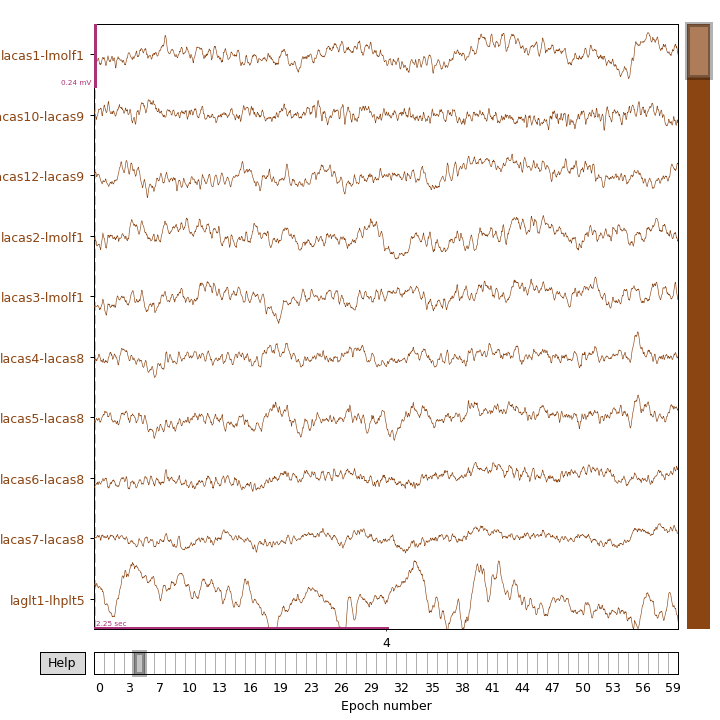

In [116]:
%matplotlib notebook
fig = epochs.plot(n_epochs=1, n_channels=10, scalings=epochs._data.max()/25)

In [28]:
# Need this following line to save the annotations to the epochs object 
fig.fake_keypress('a')

Dropped 1 epoch: 5
The following epochs were marked as bad and are dropped:
[5]
Channels marked as bad:
['laimm12-laimm11', 'lmolf4-laimm6']
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[5]
Channels marked as bad:
['laimm12-laimm11', 'lmolf4-laimm6']


You can examine information about the epochs you dropped: 

In [29]:
# Check the epoch annotations 
epochs.get_annotations_per_epoch

<bound method EpochAnnotationsMixin.get_annotations_per_epoch of <Epochs |  59 events (all good), -2 - 2.49805 sec, baseline -1 – 0 sec, ~120.5 MB, data loaded, with metadata,
 'gamble_feedback': 59>>

In [30]:
epochs.drop_log

((),
 (),
 (),
 (),
 (),
 ('USER',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ())

## Save the epoched data and use for plots

Because most of your downstream analyses will operate on these epoched data, let's save them. Also, in the interest of reproducability, these will likely be the data you share (see: https://oir.nih.gov/sourcebook/intramural-program-oversight/intramural-data-sharing/2023-nih-data-management-sharing-policy)

**Bad epochs will be dropped before saving the epochs to disk**

In [42]:
epochs.save(f'{load_dir}/feedback-epo.fif', overwrite=True)

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. Let's set some parameters first

In [31]:
# power parameters 
freqs = np.logspace(*np.log10([4, 128]), num=20)
n_cycles = 4  
sr = epochs.info['sfreq']
buf_ix = int(buf*sr)

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

Use the metadata to assign conditions to parse your epochs!

In [37]:
temp_pow.apply_baseline?

In [63]:
data_parsing = ['reward==1',
                'reward==0'
               ]


diff_pow_epochs = {f'{x}':np.nan for x in data_parsing}

# baseline_pow = mne.time_frequency.tfr_morlet(baseline_epochs, picks=picks,
#                                      freqs=freqs, n_cycles=n_cycles, use_fft=True,
#                 return_itc=False, n_jobs=-1, average=False)

# Compute power without averaging over events
for parsing in data_parsing: 
    temp_pow = mne.time_frequency.tfr_morlet(epochs[parsing], picks=picks,
                                             freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, n_jobs=-1, average=False)
    # Baseline correct the TFRs
    temp_pow = temp_pow.apply_baseline(baseline=(-feedback_pre, 0), mode='zscore')
#     baseline_pow.crop(tmin=-baseline_pre, tmax=baseline_post)
#     temp_pow.data = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, baseline_pow.data)
    temp_pow.crop(tmin=-feedback_pre, tmax=feedback_post)
    diff_pow_epochs[parsing] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.9s finished


Adding metadata with 4 columns
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    1.9s finished


Adding metadata with 4 columns
Applying baseline correction (mode: zscore)


In [34]:
%matplotlib inline

In [36]:
# Plot: 

freqs = np.logspace(*np.log10([4, 128]), num=20)

for parsing in data_parsing: 
    save_file = f'{load_dir}/gamble_TFR_{parsing}.pdf'
    with PdfPages(save_file) as pdf:
        for label in diff_pow_epochs[parsing].ch_names: 
            plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
            region_label = elec_df[elec_df.label==label].YBA_1.values[0]
            if region_label == 'Unknown':
                region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]
#             plot_data = np.mean(diff_pow_epochs[parsing].data[:, plot_ix, :, :], axis=0)
            plot_data = np.mean(diff_pow_epochs[parsing].data[:, plot_ix, :, :], axis=0)


            f, tfr = plt.subplots(1, 1, figsize=[7, 4], dpi=300)

            tfr.imshow(plot_data, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-3, vmax=3)
            tfr.invert_yaxis()

            # neg_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
            tfr.set_yticks(np.arange(0, len(freqs), 4))
            tfr.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
            tfr.set_xticks(np.linspace(0, plot_data.shape[-1], plot_data.shape[-1]//250))
            tfr.set_xticklabels(np.linspace(-(feedback_pre*1000), feedback_post*1000, plot_data.shape[-1]//250))
            tfr.set_xlabel('Time (ms)', fontsize=12)
            tfr.set_ylabel('Frequency (Hz)', fontsize=12)
            tfr.vlines((feedback_pre * diff_pow_epochs[parsing].info['sfreq']), 0, len(freqs)-1, 'k')

            f.suptitle(f'{region_label}')
            f.tight_layout()
            pdf.savefig()
            plt.close(f)

## Statistical Analyses:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

As an example, let's say I want to compare the reward vs. no-reward conditions for every channel, and identify the timepoints and frequencies that exhibit significant differences between conditions. To do so, I would utilize a non-parametric cluster-permutation test.

Left hippocampus pes
Right middle frontal gyrus 5 A
Right inferior middle temporal gyrus E


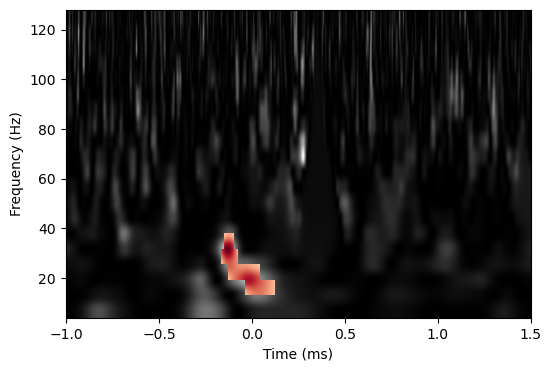

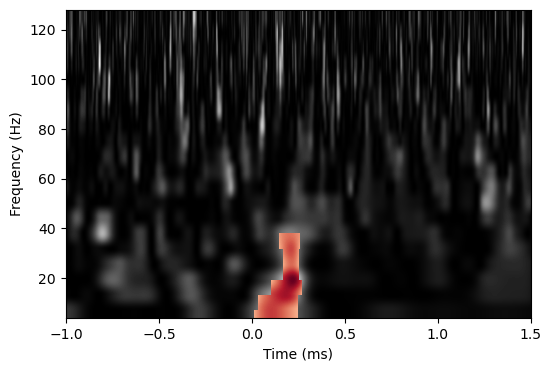

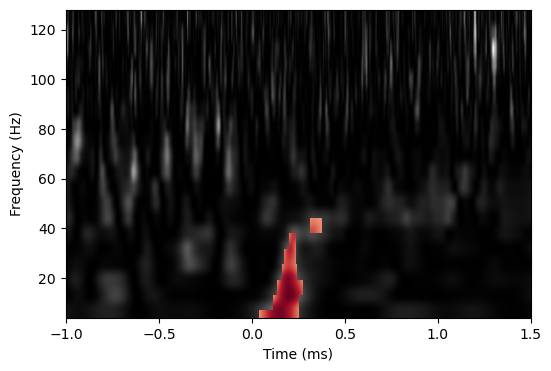

In [106]:
for label in diff_pow_epochs[parsing].ch_names: 
    region_label = elec_df[elec_df.label==label].YBA_1.values[0]
    if region_label == 'Unknown':
        region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

    plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
    
    X = [diff_pow_epochs['reward==1'].data[:, plot_ix, :, :], 
         diff_pow_epochs['reward==0'].data[:, plot_ix, :, :]]
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_test(X, n_permutations=250, out_type='mask', verbose=False)
    
    if any(cluster_p_values<0.05):
        print(region_label)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        times = diff_pow_epochs['reward==0'].times

        evoked_power_1 = X[0].mean(axis=0)
        evoked_power_2 = X[1].mean(axis=0)
        evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power_contrast)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Frequency (Hz)')
        # # ax.set_title(f'Induced power ({ch_name})')
    
    

In [89]:
# # Create new stats image with only significant clusters
# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))

# times = diff_pow_epochs['reward==0'].times

# evoked_power_1 = X[0].mean(axis=0)
# evoked_power_2 = X[1].mean(axis=0)
# evoked_power_contrast = evoked_power_1 - evoked_power_2
# signs = np.sign(evoked_power_contrast)

# F_obs_plot = np.nan * np.ones_like(F_obs)
# for c, p_val in zip(clusters, cluster_p_values):
#     if p_val <= 0.05:
#         F_obs_plot[c] = F_obs[c] * signs[c]

# ax.imshow(F_obs,
#           extent=[times[0], times[-1], freqs[0], freqs[-1]],
#           aspect='auto', origin='lower', cmap='gray')
# max_F = np.nanmax(abs(F_obs_plot))
# ax.imshow(F_obs_plot,
#           extent=[times[0], times[-1], freqs[0], freqs[-1]],
#           aspect='auto', origin='lower', cmap='RdBu_r',
#           vmin=-max_F, vmax=max_F)

# ax.set_xlabel('Time (ms)')
# ax.set_ylabel('Frequency (Hz)')
# # ax.set_title(f'Induced power ({ch_name})')